# 1. Описание датасета

### Общее описание
Датасет Alpaca* состоит из пары "инструкция – ответ" (instruction-following dataset), которая была автоматически сгенерирована на основе вопросов и инструкций, созданных моделью text-davinci-003.

Примечание: я использую [отчищенную версию alpaca](https://huggingface.co/datasets/yahma/alpaca-cleaned), где уже удалили галюцинации, пропуски и так далее.

### Задачи
**Instruction-following.** Основная цель этого датасета - обучать модель следованию инструкциям, где на вход подается какая-то задача и модель должна сгенерировать корректный ответ.

Отличительной особенностью этого датасета, является то, что ответы, которые модель должна генерировать - эти ответы были сгенерированы text-davinci-003, более мощной моделью, чем та, что использовалась в оригинальной статьи, таким образом, дополнительная цель датасета, создание мощных моделей с ограниченными ресурсами, чтобы зафайнтюнить слабую модель так, чтобы она выдавала ответы, как модели мощнее нее.

### Данные

**1) Язык:** только EN

**2) Количество записей:** примерно 52 000

**3) Вид данных:** все данные представлены в виде текста (звук отсутствует), данные имеют вид

> **instruction:** описывает задачу, которую должна выполнить модель. Каждая из 52 тысяч инструкций уникальна.

> **input:** необязательный контекст или ввод для задачи. Например, если инструкция — "Суммируйте следующую статью", то вводом является сама статья. Примерно 40% примеров содержат поле input.

> **output:** ответ на инструкцию, сгенерированный моделью text-davinci-003.

# Анализ данных

In [27]:
!pip install datasets textstat

In [ ]:
# добавляем пути

import os
import sys
nb_dir = os.path.join(os.path.split(os.getcwd())[0], 'examples')
sys.path.append(nb_dir)
print(dir())

In [31]:
import re
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from dataclasses import dataclass
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from nltk import ngrams, FreqDist
from nltk.corpus import stopwords
import spacy
from alpaca import get_dataset_iterator_alpaca

In [3]:
# загрузим датасет

records = list(get_dataset_iterator_alpaca())

df = pd.DataFrame([{
        'instruction': item.instruction,
        'input': item.input,
        'output': item.output
    } for item in records])

df.head()

Загружаем датасет 'alpaca'...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Датасет 'alpaca' был успешно загружен


,instruction,input,output
0,Give three tips for staying healthy.,,1. Eat a balanced and nutritious diet: Make su...
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye..."
2,Describe the structure of an atom.,,An atom is the basic building block of all mat...
3,How can we reduce air pollution?,,There are several ways to reduce air pollution...
4,Pretend you are a project manager of a constru...,,I had to make a difficult decision when I was ...


In [26]:
# 1. Проверка на пустые строки и None

def calculate_null_percentage(df):
    null_percentage = {}
    for column in df.columns:
        null_count = df[column].isnull().sum() + (df[column] == '').sum() + (df[column] == ' ').sum()
        total_count = len(df[column])
        null_percentage[column] = (null_count / total_count) * 100 if total_count > 0 else 0
    return null_percentage

# Вычисление и вывод процентов
null_percentage = calculate_null_percentage(df)
null_percentage_df = pd.DataFrame(null_percentage.items(), columns=['Column', 'Процент None/пустой строки'])
print("Процент пустых строк и null значений в каждой колонке:")
print(null_percentage_df)

Процент пустых строк и null значений в каждой колонке:
        Column  Процент None/пустой строки
0  instruction                    0.000000
1        input                   62.988794
2       output                    0.000000


In [12]:
# 2. Подсчет общего количества символов
total_characters = {
    "instruction": df['instruction'].str.len().sum(),
    "input": df['input'].str.len().sum(),
    "output": df['output'].str.len().sum(),
}


total_characters_all = sum(total_characters.values())

print("Общее количество символов:")
for column, total in total_characters.items():
    print(f"{column}: {total:,.0f}")
print(f"Все колонки: {total_characters_all:,.0f}")

Общее количество символов:
instruction: 3,230,407
input: 1,259,649
output: 35,141,676
Все колонки: 39,631,732


In [10]:
# 3. Проверка длины текстов

df['instruction_length'] = df['instruction'].apply(len)
df['input_length'] = df['input'].apply(lambda x: len(x) if x else 0)
df['output_length'] = df['output'].apply(len)

# Статистика по длине текстов
stats_df = pd.DataFrame({
    'Средняя': [df['instruction_length'].mean(), df['input_length'].mean(), df['output_length'].mean()],
    'Медианная': [df['instruction_length'].median(), df['input_length'].median(), df['output_length'].median()],
    'Минимальная': [df['instruction_length'].min(), df['input_length'].min(), df['output_length'].min()],
    'Максимальная': [df['instruction_length'].max(), df['input_length'].max(), df['output_length'].max()]
}, index=['Instruction', 'Input', 'Output'])

print("Таблица распределения длины текстов:")
print(stats_df)

Таблица распределения длины текстов:
                Средняя  Медианная  Минимальная  Максимальная
Instruction   62.411264       57.0            9          2220
Input         24.336341        0.0            0          2638
Output       678.935008      477.0            1          4522


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


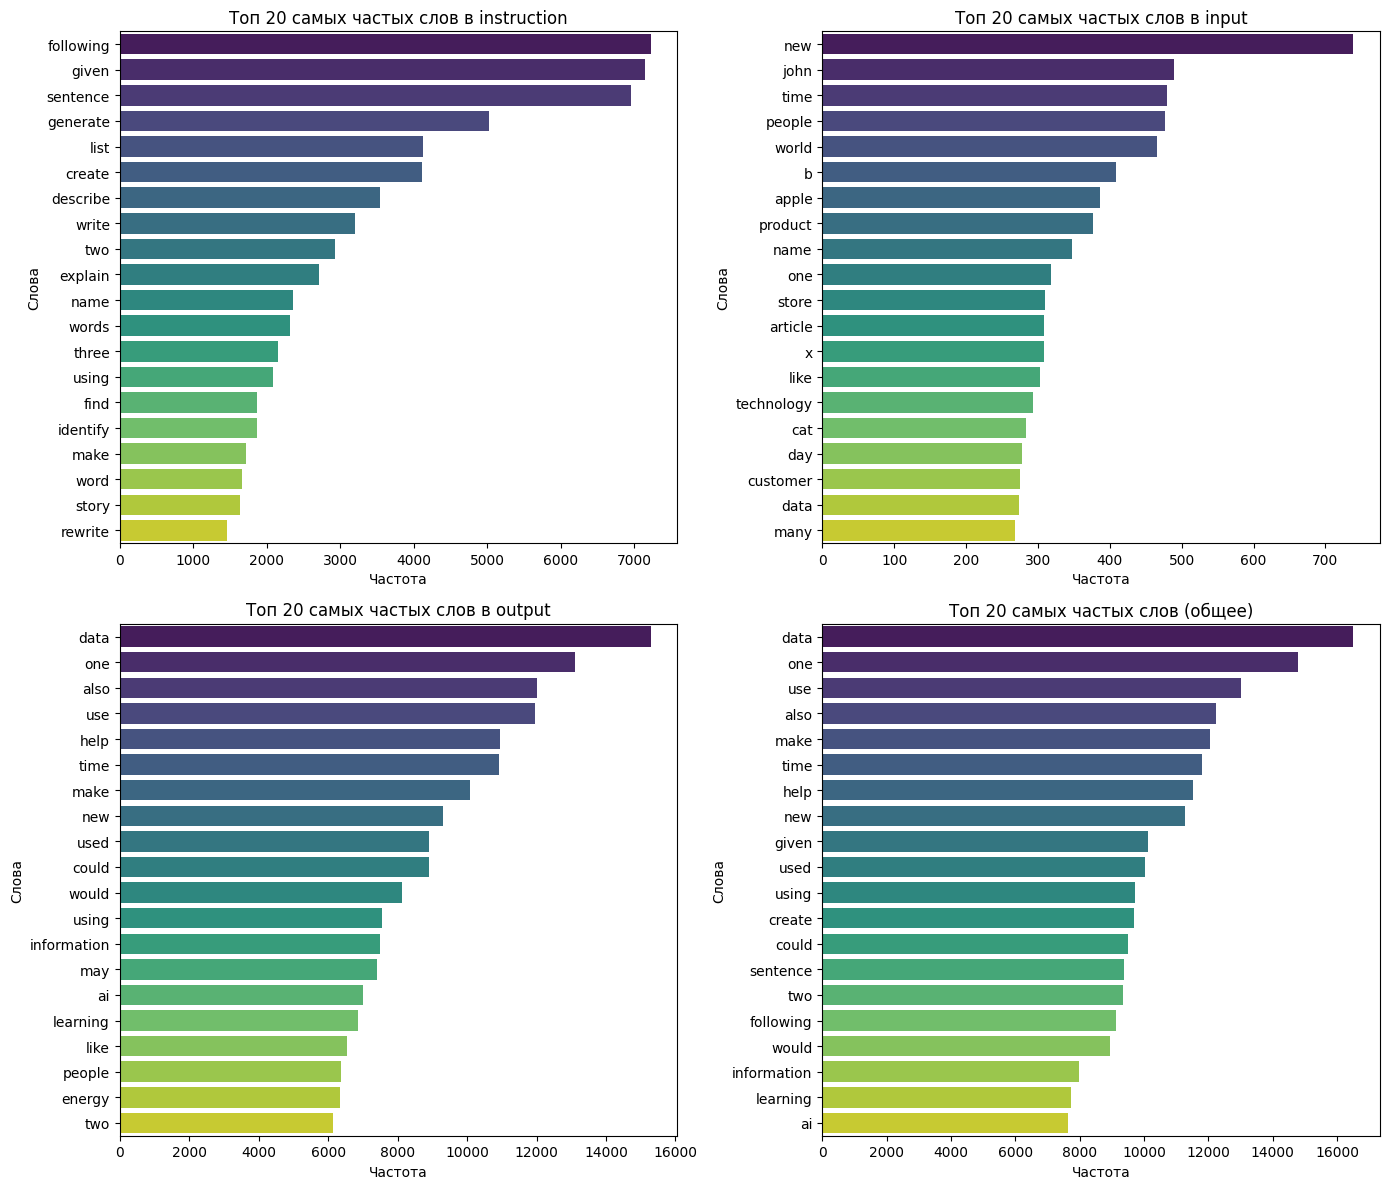

In [5]:
# 4. Частотный анализ слов

# Скачиваем стоп слова из nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# число самых популярных слов для подсчета
N = 20

# Препроцесс текста
def preprocess_text(text):
    if pd.isnull(text):
        return []
    # оставляем только буквы
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    words = text.split()
    # и не-стоп-слова
    return [word for word in words if word not in stop_words]

# Функция отрисовки графиков
def plot_top_words(word_counts, title, ax):
    words, counts = zip(*word_counts)
    sns.barplot(x=list(counts), y=list(words), ax=ax, palette='viridis', hue=list(words), legend=False)
    ax.set_title(title)
    ax.set_xlabel('Частота')
    ax.set_ylabel('Слова')

# препроцесс
instruction_words = df['instruction'].apply(preprocess_text).explode()
input_words = df['input'].apply(preprocess_text).explode()
output_words = df['output'].apply(preprocess_text).explode()
all_words = pd.concat([instruction_words, input_words, output_words])

# считаем слова
instruction_word_counts = Counter(instruction_words)
input_word_counts = Counter(input_words)
output_word_counts = Counter(output_words)
all_word_counts = Counter(all_words)

# Получение N самых частых слов
instruction_most_common = instruction_word_counts.most_common(N)
input_most_common = input_word_counts.most_common(N)
output_most_common = output_word_counts.most_common(N)
all_most_common = all_word_counts.most_common(N)

# вывод графиков
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
plot_top_words(instruction_most_common, f'Топ {N} самых частых слов в instruction', axs[0, 0])
plot_top_words(input_most_common, f'Топ {N} самых частых слов в input', axs[0, 1])
plot_top_words(output_most_common, f'Топ {N} самых частых слов в output', axs[1, 0])
plot_top_words(all_most_common, f'Топ {N} самых частых слов (общее)', axs[1, 1])

plt.tight_layout()
plt.show()

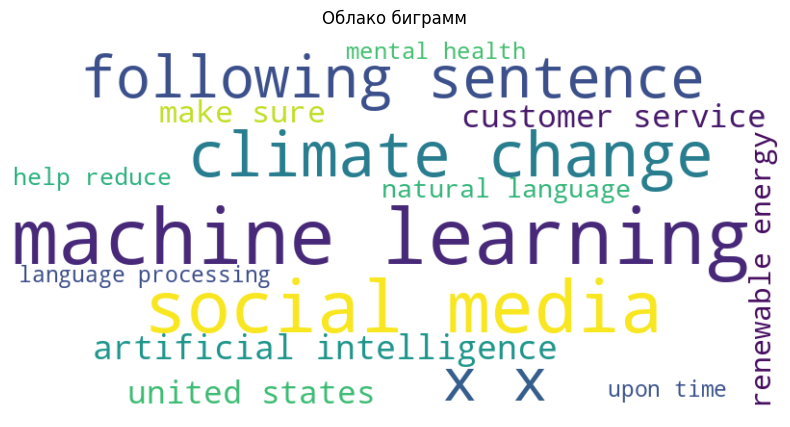

In [24]:
# 5. Частотный анализ биграмм

# чисто самых популярных биграм и триграм для вывода
M = 15

# Функция для N-грамм
def extract_ngrams(words, n):
    return list(ngrams(words, n))

bigrams = extract_ngrams(all_words, 2)
bigram_counts = Counter(bigrams)

# Преобразуем биграммы в строки
top_bigrams = bigram_counts.most_common(M)
top_bigrams_str = {f"{bigram[0]} {bigram[1]}": count for bigram, count in top_bigrams}

bigram_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_bigrams_str)
plt.figure(figsize=(10, 5))
plt.imshow(bigram_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако биграмм')
plt.show()

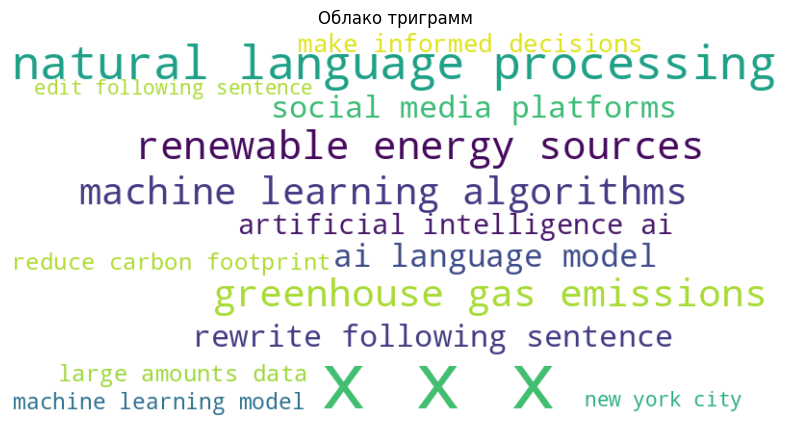

In [26]:
# 6. Частотный анализ триграмм

trigrams = extract_ngrams(all_words, 3)
trigram_counts = Counter(trigrams)

top_trigrams = trigram_counts.most_common(M)
top_trigrams_str = {f"{trigram[0]} {trigram[1]} {trigram[2]}": count for trigram, count in top_trigrams}

trigram_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_trigrams_str)
plt.figure(figsize=(10, 5))
plt.imshow(trigram_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако триграмм')
plt.show()

# Выводы

* Его основое назначение, в зависимости от задачи, может является его основным минусом: данный датасет по сути является датасетом для файнтюнинга маленьких моделей (7-13b), для того, чтобы они достигали уровня ответов более сложных моделей (таких как GPT3). Он не является датасетом для обучения LLM с нуля.
* Датасет является относительно устаревшим, так как в нем содержатся ответы модели GPT3, а на данный момент есть уже GPT4 (датасет из ответов GPT4 был бы новее чем текущий).
* Содержит синтетические данные (так как все outputs - ответы другой модели).
* Относительно большой по размеру


